# Model Order Reduction & Machine Learning - Project
## Nonlinear Elliptic problem (NEP) POD and POD-NN


In [1]:
import sys
sys.path.append('../../CppToPython')

In [2]:
import numpy as np
import GeDiM4Py as gedim
from scipy.sparse.linalg import splu
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
from torch.autograd import Variable

In [3]:
# Run to avoid to many warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
lib = gedim.ImportLibrary("../../CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

In [5]:
np.random.seed(23)

# PART 1 - Problem definition
Let us consider the two-dimensional spatial domain $\Omega = (0, 1)^2$. We want to solve the following parametrized problem: given $\mu = (\mu_0, \mu_1) \in \mathcal{P} = [0.1, 1]^2$, find $u(\mu)$ such that
$$
-\Delta u(\mu) + \frac{\mu_0}{\mu_1} (e^{\mu_1 u(\mu)} - 1) = g(x;\mu) \text{  (NEP1)}
$$
with homogeneous Dirichlet condition on the boundary, i.e. zero-boundary condition.

The forcing term, that does not depend on the parameters, defined as
$$
g(x;\mu) = g_1 = 100 \sin(2\pi x_0) \cos(2\pi x_1) \quad \forall x = (x_0, x_1) \in \Omega.
$$

**Tasks:**

1. Solve the problem by means of POD-Galerkin method over a Finite Element full order model -> using high fidelity element approximation of POD
2. Solve the problem with a parametric PINN -> find the NN structure to reduce the problem
3. Compare the two approaches in terms of computational costs and accuracy with respect to the full order model -> compare in terms of execution time & error
4. **Optional:** Solve the problem with the POD-NN approach and compare it to the other two strategies.

## 1.1 High fidelity solution of NEP1
#### Problem terms definition

In [6]:
# Points on which we want to integrate - We leave the structure of Lab12

# Points for the diffusion term
def Elliptic_a(numPoints, points): 
	values_a = np.ones(numPoints, order='F') # Fortran order of memorization of the matrix: column by column
	return values_a.ctypes.data

# Points for the reaction term
def Elliptic_c(numPoints, points):
	values_c = np.ones(numPoints, order='F') 
	return values_c.ctypes.data    

In [7]:
def Elliptic_non_linear_c(numPoints, points, u, u_x, u_y):
	vec_u = gedim.make_nd_array(u, numPoints, np.double) # Evaluation of the function in the quadrature points numPoints
	values_nl_c = vec_u
	return values_nl_c.ctypes.data

In [8]:
def Elliptic_non_linear_der_f(numPoints, points, u, u_x, u_y):
    # Converts u_x and u_y pointers or arrays to NumPy arrays
	vecu_x = gedim.make_nd_array(u_x, numPoints, np.double)
	vecu_y = gedim.make_nd_array(u_y, numPoints, np.double)
    
	values_nl_d_f = np.zeros((2, numPoints), order='F')

    # Inserts the partial derivatives of u into the new array values_nl_d_f
	values_nl_d_f[0,:] = vecu_x
	values_nl_d_f[1,:] = vecu_y
    
	return values_nl_d_f.ctypes.data

In [9]:
# Nonlinear reaction term
def Elliptic_non_linear_f(numPoints, points, u, u_x, u_y): 
    vec_u = gedim.make_nd_array(u, numPoints, np.double)
    vecu_x = gedim.make_nd_array(u_x, numPoints, np.double)
    vecu_y = gedim.make_nd_array(u_y, numPoints, np.double)
    
    values_nl_f = (mu_0/mu_1) * (np.exp(mu_1*vec_u)-1) # Computation of f
    
    return values_nl_f.ctypes.data

In [10]:
def Ones(numPoints, points):
	values_one = np.ones(numPoints, order='F')
	return values_one.ctypes.data

def OnesDerivative(numPoints, points):
	values_one_d = np.ones((2, numPoints), order='F')
	return values_one_d.ctypes.data

def Zeros(numPoints, points):
	values_zero = np.zeros(numPoints, order='F')
	return values_zero.ctypes.data

def ZerosDerivative(direction, numPoints, points):
	values_zero_d = np.zeros(numPoints, order='F')
	return values_zero_d.ctypes.data

In [11]:
# Definition of the forcing term g_1
def Elliptic_g_1(numPoints, points): 
    matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double) # X
    # g_1(X,mu) = 100*sin(2pi*x)*cos(2pi*y), X=(x,y)
    values_g = 100*np.sin(2*np.pi*matPoints[0,:])*np.cos(2*np.pi*matPoints[1,:])
    return values_g.ctypes.data

In [12]:
order = 1 # Start from 1, at the END we will decide if we have to improve the order
P = [0.1, 1.] # Parametric space

#### Mesh and domain definition

In [13]:
# Fix the right domain
mesh_size = 0.00312

# Updating the domain wrt the mesh_size
domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': mesh_size } 
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib) 
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] } # 2 := Dirichlet boundary condition
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

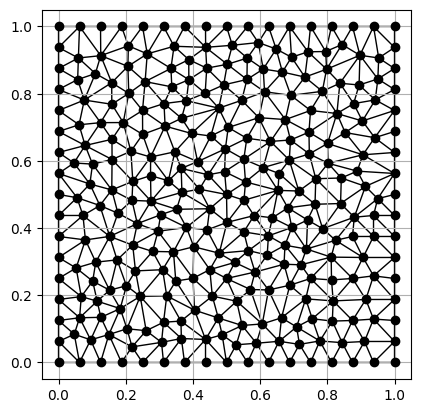

In [14]:
gedim.PlotMesh(mesh)

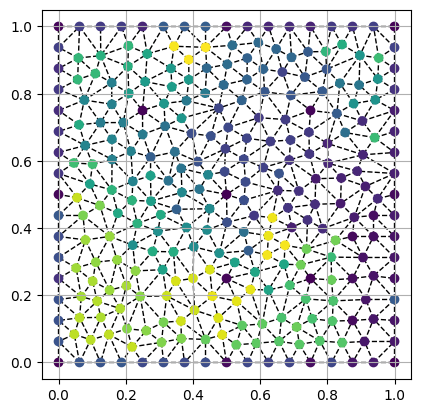

In [15]:
gedim.PlotDofs(mesh, dofs, strongs)

In [16]:
# Initialization of the guess of the solution --> the NM converges rapidly if we start not far away from the solution
u_k = np.zeros(problemData['NumberDOFs'], order='F') 
u_strong = np.zeros(problemData['NumberStrongs'], order='F') # Vector containing the strongly imposed components of the solution, ie Dirichlet conditions

#### Newton method for high fidelity snapshots computation

In [ ]:
####### ASSEMBLE EVERYTHIING AT EVERT ITERATION
# RELATIVO A G_1
sample_mu_0 = np.random.uniform(0.1, 1, 100) # Uniform sampling in mu_Rang of 100 samples
sample_mu_1 = np.random.uniform(0.1, 1, 100)

snapshots_matrix = []
convergence_history = []  
max_iterations = 100
newton_tol = 1e-8
sol_quad_hf = []

for mu_0, mu_1 in zip(sample_mu_0, sample_mu_1):
    
    # Set Newton parameter at each change of the parameter
    du_norm = 1.0
    u_k_norm = 1.0
    num_iteration = 1
    du_norms_for_sample = []
    num_iteration = 1
    rel_error = 0

    # Iterative step - Setting a relative tollerance
    while num_iteration < max_iterations and du_norm > newton_tol * u_k_norm: 

        # 1- Left side of the equation
        
        # Linear
        [stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Elliptic_a, problemData, lib) # Indipendent from mu_0 & mu_1
        # Non linear 
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Elliptic_c, Elliptic_non_linear_c, u_k, u_strong, problemData, lib)
       
        # 2- Right hand side of the function
        
        # Linear part
        forcingTerm_g = gedim.AssembleForcingTerm(Elliptic_g_1, problemData, lib)
        # Non linear part
        forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Elliptic_non_linear_f, u_k, u_strong, problemData, lib)
        forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Elliptic_non_linear_der_f, u_k, u_strong, problemData, lib)
    
        # Solving with the LU solver because we're in a generic setting (no idea of the structure of the matrix)
        # CAN WE DONE BETTER?
        du = gedim.LUSolver(stiffness + reaction, \
                forcingTerm_g - forcingTerm_v - forcingTerm_der_v, \
                lib)
        
        u_k = u_k + du # Update
        
        # Compute norm for stopping criterium
        du_norm = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)  # ||du|| = ||u(k) - u(k-1)|| L^2-norm
        du_norms_for_sample.append(du_norm)
        u_k_norm = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib) # ||u_k|| L^2-norm

    
        # Compute the relative error of two consecutive iterations
        rel_error = du_norm / u_k_norm       
        
        num_iteration = num_iteration + 1

    snapshots_matrix.append(np.copy(u_k))
    convergence_history.append(du_norms_for_sample)

    # Compute the sol on the quadrature points
    [numQuadraturePoints, quadraturePoints, quadratureWeights, solution_hf, solution_x_hf, solution_y_hf] = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)
    # append solution on qudrature points
    sol_quad_hf.append(solution_hf)

    # Print at the end of the iteration before the change of the parameter
    print(f"{'mu_0':<10} {'mu_1':<10} {'iters':<6} {'rel_err_L2':<14}")
    print(f"{mu_0:<10.4f} {mu_1:<10.4f} {(num_iteration-1):<6d} {rel_error:<14.2e}")

snapshots_matrix = np.array(snapshots_matrix)
print(f"snapshots_matrix.shape: {snapshots_matrix.shape}")
last_u_k_exact = u_k

In [ ]:
####### ASSEMBLE ONCE OFFLINE AND ONLY NECESSARY STUFF AT EVERT ITERATION
# RELATIVO A G_1
sample_mu_0 = np.random.uniform(0.1, 1, 100) # Uniform sampling in mu_Rang of 100 samples
sample_mu_1 = np.random.uniform(0.1, 1, 100)

snapshots_matrix = []
convergence_history = []  
max_iterations = 300
newton_tol = 1e-8
sol_quad_hf = []

# OFFLINE PHASE: ASSEMBLING STUFF NON PARAMETER DEPENDANT
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Elliptic_a, problemData, lib) # linear part 
forcingTerm_g = gedim.AssembleForcingTerm(Elliptic_g_1, problemData, lib) # linear part
forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Elliptic_non_linear_der_f, u_k, u_strong, problemData, lib) # non linear

for mu_0, mu_1 in zip(sample_mu_0, sample_mu_1):
    
    # Set Newton parameter at each change of the parameter
    du_norm = 1.0
    u_k_norm = 1.0
    num_iteration = 1
    du_norms_for_sample = []
    num_iteration = 1
    rel_error = 0

    # Iterative step - Setting a relative tollerance
    while num_iteration < max_iterations and du_norm > newton_tol * u_k_norm:
        

        # ONLINE PHASE : ASSEMBLE STUFF PARAMETER DEPENDANT
        # 1- Left side of the equation
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Elliptic_c, Elliptic_non_linear_c, u_k, u_strong, problemData, lib) # Non linear 
        # 2- Right hand side of the function
        forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Elliptic_non_linear_f, u_k, u_strong, problemData, lib) # Non linear part
    
        # Solving with the LU solver because we're in a generic setting (no idea of the structure of the matrix)
        du = gedim.LUSolver(stiffness + reaction, \
                forcingTerm_g - forcingTerm_v - forcingTerm_der_v, \
                lib)
        
        u_k = u_k + du # Update
        
        # Compute norm for stopping criterium
        du_norm = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)  # ||du|| = ||u(k) - u(k-1)|| L^2-norm
        du_norms_for_sample.append(du_norm)
        u_k_norm = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib) # ||u_k|| L^2-norm

    
        # Compute the relative error of two consecutive iterations
        rel_error = du_norm / u_k_norm       
        
        num_iteration = num_iteration + 1

    snapshots_matrix.append(np.copy(u_k))
    convergence_history.append(du_norms_for_sample)

    # Compute the sol on the quadrature points
    [numQuadraturePoints, quadraturePoints, quadratureWeights, solution_hf, solution_x_hf, solution_y_hf] = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)
    # append solution on qudrature points
    sol_quad_hf.append(solution_hf)

    # Print at the end of the iteration before the change of the parameter
    print(f"{'mu_0':<10} {'mu_1':<10} {'iters':<6} {'rel_err_L2':<14}")
    print(f"{mu_0:<10.4f} {mu_1:<10.4f} {(num_iteration-1):<6d} {rel_error:<14.2e}")

snapshots_matrix = np.array(snapshots_matrix)
print(f"snapshots_matrix.shape: {snapshots_matrix.shape}")

last_u_k_exact = u_k

mu_0       mu_1       iters  rel_err_L2    
0.1610     0.8624     99     2.85e-03      
mu_0       mu_1       iters  rel_err_L2    
0.7492     0.4082     99     3.00e-03      
mu_0       mu_1       iters  rel_err_L2    
0.2094     0.2304     99     2.70e-03      
mu_0       mu_1       iters  rel_err_L2    
0.8286     0.2653     99     2.93e-03      
mu_0       mu_1       iters  rel_err_L2    
0.9413     0.2472     99     1.56e-03      
mu_0       mu_1       iters  rel_err_L2    
0.4082     0.4829     99     2.25e-03      
mu_0       mu_1       iters  rel_err_L2    
0.3814     0.6450     99     1.32e-03      
mu_0       mu_1       iters  rel_err_L2    
0.6403     0.1847     99     1.22e-03      
mu_0       mu_1       iters  rel_err_L2    
0.7251     0.1241     99     8.64e-04      
mu_0       mu_1       iters  rel_err_L2    
0.1407     0.1798     99     3.87e-03      
mu_0       mu_1       iters  rel_err_L2    
0.6641     0.3445     99     2.14e-03      
mu_0       mu_1       iters  rel

Exception ignored on calling ctypes callback function: <function Zeros at 0x7fbef136c0d0>
Traceback (most recent call last):
  File "/tmp/ipykernel_4372/1217289462.py", line 11, in Zeros
  File "/usr/local/lib/python3.10/dist-packages/numpy/_core/_internal.py", line 262, in __init__
    def __init__(self, array, ptr=None):
KeyboardInterrupt: 


mu_0       mu_1       iters  rel_err_L2    
0.7174     0.8240     99     5.34e-04      
mu_0       mu_1       iters  rel_err_L2    
0.1658     0.4144     99     3.58e-03      
mu_0       mu_1       iters  rel_err_L2    
0.6053     0.2976     99     1.72e-03      
mu_0       mu_1       iters  rel_err_L2    
0.3328     0.8271     99     1.61e-03      
mu_0       mu_1       iters  rel_err_L2    
0.2991     0.5293     99     1.02e-03      
mu_0       mu_1       iters  rel_err_L2    
0.2036     0.1465     99     1.58e-03      
mu_0       mu_1       iters  rel_err_L2    
0.1892     0.4411     99     1.23e-03      
mu_0       mu_1       iters  rel_err_L2    
0.3195     0.5399     99     6.42e-04      
mu_0       mu_1       iters  rel_err_L2    
0.7714     0.7099     99     3.50e-03      


Exception ignored on calling ctypes callback function: <function Elliptic_non_linear_c at 0x7fbef12bfeb0>
Traceback (most recent call last):
  File "/tmp/ipykernel_4372/1925887592.py", line 2, in Elliptic_non_linear_c
  File "/content/RBM_ML_2025/Lab13/../../CppToPython/GeDiM4Py.py", line 36, in make_nd_array
    arr_size = np.prod(size) * np.dtype(dtype).itemsize 
  File "/usr/local/lib/python3.10/dist-packages/numpy/_core/fromnumeric.py", line 3445, in prod
    return _wrapreduction(a, np.multiply, 'prod', axis, dtype, out,
  File "/usr/local/lib/python3.10/dist-packages/numpy/_core/fromnumeric.py", line 86, in _wrapreduction
    return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
KeyboardInterrupt: 


mu_0       mu_1       iters  rel_err_L2    
0.6349     0.3685     99     1.28e-03      
mu_0       mu_1       iters  rel_err_L2    
0.5831     0.1136     99     7.56e-04      
mu_0       mu_1       iters  rel_err_L2    
0.4380     0.6396     99     1.05e-03      
mu_0       mu_1       iters  rel_err_L2    
0.3115     0.8376     99     1.65e-03      
mu_0       mu_1       iters  rel_err_L2    
0.6317     0.2893     99     1.76e-03      
mu_0       mu_1       iters  rel_err_L2    
0.8575     0.6704     99     1.76e-03      
mu_0       mu_1       iters  rel_err_L2    
0.5296     0.7585     99     1.12e-03      
mu_0       mu_1       iters  rel_err_L2    
0.1754     0.9709     99     3.16e-03      
mu_0       mu_1       iters  rel_err_L2    
0.9399     0.1790     99     3.43e-03      


In [18]:
# Plot and show the solution
gedim.PlotSolution(mesh, dofs, strongs, last_u_k_exact, u_strong)
[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(last_u_k_exact, u_strong, lib)
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, last_u_k_exact, lib)
print(f"quadratureWeights: {quadratureWeights}")

gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib) # To export solutions on paraview

NameError: name 'last_u_k_exact' is not defined

## 1.2 POD of NEP1

In [ ]:
# We assemble here the covariance matrix and inner prod matrix
#[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Elliptic_a, problemData, lib)
inner_product = stiffness 

# Definitio of the covariance matrix
C = snapshots_matrix @ inner_product @ np.transpose(snapshots_matrix) 

In [ ]:
# Eigenvalue problem
tol = 1. - 1e-7

L_e, VM_e = np.linalg.eig(C)
eigenvalues = []
eigenvectors = []

for i in range(len(L_e)):
  eig_real = L_e[i].real
  eig_complex = L_e[i].imag
  assert np.isclose(eig_complex, 0.) # We need a symmetic positive definite matrix: all eigenvalues real and positive
  eigenvalues.append(eig_real)
  eigenvectors.append(VM_e[i].real)


total_energy = sum(eigenvalues) # Sum of all the eigenvalues
retained_energy_vector = np.cumsum(eigenvalues) # Cumulative sum (summing until n)
relative_retained_energy = retained_energy_vector/total_energy # "Percentage"

# We want the first term for that the relative_retained_energy is less then 1 - 1e-7
if all(flag==False for flag in relative_retained_energy>= tol): 
  N = N_max
else:
  N = np.argmax(relative_retained_energy >= tol) + 1 # Python works from 0, but the basis goes from 1

# I need 3 basis (see the resutl) to show everything, this means that with 3 
# eigenvalues we reach the condition, and all the other are very very small (irrelevant)
print("The reduced dimension is N =", N) 

In [ ]:
N = 3

plt.figure(figsize=(9, 6)) # Slightly larger figure for better readability

# Plot the cumulative energy
# Using a slightly darker pastel blue and smaller marker for a cleaner look
plt.plot(range(1, len(relative_retained_energy) + 1), relative_retained_energy,
         marker='o', markersize=4, linestyle='-', color='#6495ED', # CornflowerBlue
         label='Cumulative Energy')

# Horizontal line for the tolerance threshold
plt.axhline(y=tol, color='#FF6347', linestyle='--', linewidth=1.5, # Tomato
            label=f'Tolerance Threshold: {tol:.7f}')

# Vertical line for N
# Get the value of cumulative energy at N
if 1 <= N <= len(relative_retained_energy):
    energy_at_N = relative_retained_energy[N - 1]
    # Format the energy value to be readable (e.g., 5 decimal places or scientific notation if very small)
    formatted_energy_at_N = f'{energy_at_N:.5f}' if energy_at_N > 0.001 else f'{energy_at_N:.2e}'
    plt.axvline(x=N, color='#32CD32', linestyle='--', linewidth=1.5, # LimeGreen
                label=f'N = {N} (Energy: {formatted_energy_at_N})') # Added formatted energy value to label
else:
    plt.axvline(x=N, color='#32CD32', linestyle='--', linewidth=1.5, # LimeGreen
                label=f'N = {N}') # Fallback if N is out of bounds

# Customize labels and title with slightly larger fonts for better visibility
plt.xlabel('Number of Eigenvalues Considered', fontsize=12)
plt.ylabel('Cumulative Relative Energy', fontsize=12)
plt.title('Decay of Cumulative Energy and Selection of N', fontsize=14)

# Add grid lines for better readability
plt.grid(True, which="both", ls="-", alpha=0.6) # Solid grid lines, slightly transparent

plt.legend(loc='lower right', fontsize=10) # Position legend for better fit
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

#### Offline phase

In [ ]:
# Create the basis function matrix
basis_functions = []
for n in range(N):
  eigenvector =  eigenvectors[n]
  
  basis = np.transpose(snapshots_matrix)@eigenvector
  norm = np.sqrt(np.transpose(basis) @ inner_product @ basis) # ||u||_H^1 = u'Xu 
  
  basis /= norm # Normalizing
  basis_functions.append(np.copy(basis)) # Have all together all the basis

basis_functions = np.transpose(np.array(basis_functions))

In [ ]:
# ASSEMBLE OFFLINE STUFF (NON PARAMETER DEPENDANT)
# Reduce operator
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Elliptic_a, problemData, lib)
reduced_stiff = np.transpose(basis_functions) @ stiffness @ basis_functions

# Assemble the forcing term (all the right part of the equation)
forcingTerm_g = gedim.AssembleForcingTerm(Elliptic_g_1, problemData, lib) # NO PARAMETRI
forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Elliptic_non_linear_der_f, u_k, u_strong, problemData, lib) # NO PARAMETRI

reduced_forcingTerm_g =  np.transpose(basis_functions) @ forcingTerm_g
reduced_forcingTerm_der_v =  np.transpose(basis_functions) @ forcingTerm_der_v 

### OFFLINE STOP

In [ ]:
test_mu_0 = np.random.uniform(0.1, 1, 1)
test_mu_1 = np.random.uniform(0.1, 1, 1)

#### Online phase

In [ ]:
### ONLINE START
# 1) FIX MU_0, MU_1
mu_0 =  test_mu_0
mu_1 =  test_mu_1
#print(mu_0,mu_1)

# 2)
# Assemble reaction online
[reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Elliptic_c, Elliptic_non_linear_c, u_k, u_strong, problemData, lib) # Sì PARAMETRI
reduced_react = np.transpose(basis_functions) @ reaction @ basis_functions # Projection

# Assemble forcing term online
forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Elliptic_non_linear_f, u_k, u_strong, problemData, lib) # Sì PARAMETRI
reduced_forcingTerm_v =  np.transpose(basis_functions) @ forcingTerm_v 

reduced_lhs = reduced_stiff + reduced_react
reduced_rhs = reduced_forcingTerm_g - reduced_forcingTerm_v - reduced_forcingTerm_der_v

In [ ]:
# 3)
reduced_solution = gedim.LUSolver(reduced_lhs, reduced_rhs)
#reduced_solution = np.linalg.solve(reduced_lhs, reduced_rhs)
print(reduced_solution)

In [ ]:
# 4)
# I need to project reduced_solution back to the finite element space (calligraphic N)
proj_reduced_solution = basis_functions @ reduced_solution 

#### Plot the projected reduced solution 

In [ ]:
# plot the reduce solution projected
gedim.PlotSolution(mesh, dofs, strongs, proj_reduced_solution, u_strong) 
#gedim.ExportSolution(Elliptic_exactSolution, u_k, u_strong, lib) CAPIRE COME E SE ESPORTARLA

#### Compute the full solution with same mu to plot it (for comparison)

In [ ]:
# Set Newton parameter at each change of the parameter
du_norm = 1.0
u_k_norm = 1.0
num_iteration = 1
du_norms_for_sample = []
num_iteration = 1
rel_error = 0

# Iterative step - Setting a relative tollerance
while num_iteration < max_iterations and du_norm > newton_tol * u_k_norm: 

    # WE HAVE ASSEMBLED EVERYTHING ALREADY AND WE HAVEN'T CHANGED MU--> ONLY RUN NEWTON FOR FULL SOLUTION WITH THIS TEST MU 
    # 1- Left side of the equation
    
    # Linear
    #[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Elliptic_a, problemData, lib) # Indipendent from mu_0 & mu_1
    # Non linear 
    #[reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Elliptic_c, Elliptic_non_linear_c, u_k, u_strong, problemData, lib)
    
    # 2- Right hand side of the function
    
    # Linear part
    #forcingTerm_g = gedim.AssembleForcingTerm(Elliptic_g_1, problemData, lib)
    # Non linear part
    #forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Elliptic_non_linear_f, u_k, u_strong, problemData, lib)
    #forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Elliptic_non_linear_der_f, u_k, u_strong, problemData, lib)
    
    # Solving with the LU solver because we're in a generic setting (no idea of the structure of the matrix)
    # CAN WE DONE BETTER?
    du = gedim.LUSolver(stiffness + reaction, \
            forcingTerm_g - forcingTerm_v - forcingTerm_der_v, \
            lib)
    
    u_k = u_k + du # Update
    
    # Compute norm for stopping criterium
    du_norm = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)  # ||du|| = ||u(k) - u(k-1)|| L^2-norm
    du_norms_for_sample.append(du_norm)
    u_k_norm = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib) # ||u_k|| L^2-norm
    
    
    # Compute the relative error of two consecutive iterations
    rel_error = du_norm / u_k_norm       
    
    num_iteration = num_iteration + 1
    
    # Compute the sol on the quadrature points
    [numQuadraturePoints, quadraturePoints, quadratureWeights, solution_hf, solution_x_hf, solution_y_hf] = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)
    # append solution on qudrature points
    sol_quad_hf.append(solution_hf)



full_solution = u_k
gedim.PlotSolution(mesh, dofs, strongs, full_solution, u_strong)

### Error computation of POD

In [ ]:
# Compute the error for the solution, we want to compute separate error for velocity and for pressure
def compute_error(fom_solution, rom_solution_FE_basis, inner_product=None, type_err="relative"):
    
    error_function_u = fom_solution - rom_solution_FE_basis
    
    if inner_product == None:
      inner_product_matrix = np.identity(fom_solution.shape[0])
    else:
      inner_product_matrix = inner_product
    
    error_norm_squared_component = np.transpose(error_function_u) @ inner_product_matrix @ error_function_u
    absolute_error = np.sqrt(abs(error_norm_squared_component))
    
    if type_err == "absolute":
      return absolute_error
    
    else:
      full_solution_norm_squared_component = np.transpose(fom_solution) @  inner_product_matrix @ fom_solution
      relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
    
      return relative_error

In [ ]:
abs_err_u = []
rel_err_u = []

testing_set = np.random.uniform(low=0.1, high=1, size=(100, 2))
speed_up = []

print("Computing error and speedup analysis")

for mu in testing_set:
    mu_0 = mu[0]
    mu_1 = mu[1]
    
    # REASSEMBLE ONLINE STUFF
    start_time_assemble = time.time()
    [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Elliptic_c, Elliptic_non_linear_c, u_k, u_strong, problemData, lib)
    forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Elliptic_non_linear_f, u_k, u_strong, problemData, lib)
    time_assemble = time.time() - start_time_assemble

    # FULL
    lhs = stiffness + reaction
    rhs = forcingTerm_g - forcingTerm_v - forcingTerm_der_v
    
    start_fom = time.time()
    full_solution = gedim.LUSolver(lhs, rhs, lib)
    time_fom = time.time() - start_fom
    
    # REDUCED 
    reduced_forcingTerm_v =  np.transpose(basis_functions) @ forcingTerm_v # mu_0, mu_1 dipendent
    reduced_react = np.transpose(basis_functions) @ reaction @ basis_functions # mu_0, mu_1 dipendent
    
    reduced_lhs = reduced_stiff + reduced_react
    reduced_rhs = reduced_forcingTerm_g - reduced_forcingTerm_v - reduced_forcingTerm_der_v
    
    start_rom = time.time()
    reduced_solution = np.linalg.solve(reduced_lhs, reduced_rhs)
    time_rom = time.time() - start_rom
    
    speed_up.append((time_fom)/(time_rom))
    
    reduced_solution_FE_basis = basis_functions @ reduced_solution
    
    ### computing error
    
    abs_err_u_mu = compute_error(full_solution, reduced_solution_FE_basis, inner_product=inner_product, type_err="absolute")
    rel_err_u_mu = compute_error(full_solution, reduced_solution_FE_basis, inner_product=inner_product)
    abs_err_u.append(abs_err_u_mu)
    rel_err_u.append(rel_err_u_mu)

In [ ]:
print("avarege relative error = ", np.mean(rel_err_u) )
print("avarege absolute error = ", np.mean(abs_err_u) )

print("avarege speed_up = ", np.mean(speed_up) )

print()

print(f"time_assemble: {time_assemble}")
print(f"time_fom: {time_fom}")
print(f"time_rom: {time_rom}")

# 3 POD-NN

In [ ]:
# define the net and its dimensions
mu_dim = 2 
basis_dim = N #N=3 --> found doing POD
input_dim = mu_dim # net takes mu=(mu_0,mu_1) as input
output_dim = basis_dim # net outputs a reduced solution uN of dim N=3
nodes = 40

#let us use this net for now, then we'll see
class Net(nn.Module):
    def __init__(self):
         super(Net, self).__init__()
         # Starting layer
         self.fc1 = nn.Linear(input_dim, nodes)
        
         # Hidden layer
         self.fc2 = nn.Linear(nodes, nodes)
         self.fc3 = nn.Linear(nodes, nodes)
         self.fc4 = nn.Linear(nodes, nodes)
         # Finish hidden layer
         # Last layer
         self.fc5 = nn.Linear(nodes, output_dim)
        
         self.tanh = nn.Tanh()
     # self.apply(self._init_weights)
    def forward(self, x): ### Forward law ----> prediction
         # Activation function
         x = self.tanh(self.fc1(x)) # Iperbolic tangent [-1, 1]
         x = self.tanh(self.fc2(x))
         x = self.tanh(self.fc3(x))
         x = self.tanh(self.fc4(x))
        
         x = self.fc5(x) # This is the output, we do not change the range of the solution
         # It is better to leave the final solution in the space where it is to do not modify it
        
         return x

#### Training step

In [ ]:
#set seed
seed_num = 23 # You can change this, different seed == different initialization of weight --> maybe better performance
torch.manual_seed(seed_num)

# call model, loss and optimizer (to be changed maybe)
model = Net()
torch.set_default_dtype(torch.float32)
loss = nn.MSELoss() # MSE loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# define the training parameters
epoch_max = 10000
epoch = 0
tol = 1e-5
running_loss = 1. # To start the optimization

In [ ]:
## training set definition 

# Reshape to column vectors
sample_mu_0 = sample_mu_0.reshape(-1, 1)  # shape: (200, 1)
sample_mu_1 = sample_mu_1.reshape(-1, 1)  # shape: (200, 1)

# Now concatenate column-wise
training_set = np.hstack((sample_mu_0, sample_mu_1)) # ha senso trainare sugli stessi mu con cui ho costruito newton? non conviene risamplarli??

In [ ]:
print(training_set.shape)

In [ ]:
# NB: x (= input of model) = mu , y (=output of model) = uN
reduced_inner_product = np.transpose(basis_functions) @ inner_product @ basis_functions
mu_train = torch.tensor(np.float32(training_set)) # The input are all the parameters that I have
uN_train = []
for i in range(snapshots_matrix.shape[0]):
    snapshot_to_project = snapshots_matrix[i]
    # We have to solve X_N u_rb = B^T X_delta u_delta
    projected_snapshot = np.linalg.solve(reduced_inner_product, np.transpose(basis_functions)@inner_product@snapshot_to_project)
    uN_train.append(projected_snapshot) # On dimension N=3
uN_train = np.float32(uN_train)
uN_train = torch.tensor(uN_train) # To np object to tensor

In [ ]:
##### TRAINING LOOP #######
while running_loss >= tol and epoch < epoch_max:
    epoch = epoch + 1
    optimizer.zero_grad()
    
    ## compute output
    uN_pred = model(mu_train) # Net apply to my parameter --> to each parameter I have a solution in dimension 9 that are the projection
    
    running_loss = loss(uN_pred, uN_train) # Computing the loss
    
    if epoch >= 20000:
        optimizer.param_groups[0]['lr'] = 0.0001 # To change the learning rate during the epoch with a dictionary
    
    #compute the gradients
    running_loss.backward()
    
    # optimizer update
    optimizer.step()
    
    if epoch % 600 == 199:
        print("epoch", epoch, 'loss', running_loss.item(), 'lr', optimizer.param_groups[0]['lr'] )

### Testing step

In [ ]:
mu_0 = test_mu_0
mu_1 = test_mu_1
mu_test = np.array((mu_0, mu_1)).reshape(1,-1)
mu_test = np.float32(mu_test)
print(mu_test.shape)

In [ ]:
########### TESTING PHASE ############## mu_0 = 0.2 mu_1 = 0.8
mu_test = torch.tensor(mu_test)
reduced_solution = np.asarray(model(mu_test).detach().numpy())[0] # To make comparison wrt the other
print(reduced_solution) # In dimension 3

In [ ]:
# Project the solution to see it :
nn_proj_reduced_solution = basis_functions @ reduced_solution
gedim.PlotSolution(mesh, dofs, strongs, nn_proj_reduced_solution, np.zeros(problemData['NumberStrongs'])) 

In [ ]:
#### COMPUTATION AND PLOT OF FULL SOLUTION --> WE ONLY HAVE TO REASSEMBLE ONLINE STUFF
# Linear
#[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Elliptic_a, problemData, lib) # Indipendent from mu_0 & mu_1
# Non linear 
[reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Elliptic_c, Elliptic_non_linear_c, u_k, u_strong, problemData, lib)

# 2- Right hand side of the function
# Linear part
#forcingTerm_g = gedim.AssembleForcingTerm(Elliptic_g_1, problemData, lib)
# Non linear part
forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Elliptic_non_linear_f, u_k, u_strong, problemData, lib)
#forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Elliptic_non_linear_der_f, u_k, u_strong, problemData, lib)

# Solving with the LU solver because we're in a generic setting (no idea of the structure of the matrix)
full_solution = gedim.LUSolver(stiffness + reaction, \
        forcingTerm_g - forcingTerm_v - forcingTerm_der_v, \
        lib)
gedim.PlotSolution(mesh, dofs, strongs, full_solution, u_strong) # Plotting the FOM solution (the ground trouth)

In [ ]:
#Let us perform an error analysis and comment on the speed up!
abs_err = []
rel_err = []
testing_set = np.random.uniform(low=0.1, high=1, size=(10, 2))
speed_up = []
print("Computing error and speedup analysis") # Compute the erorr
for mu in testing_set:
    mu_0 = mu[0]
    mu_1 = mu[1]
    #### ASSEMBLE STUFF PARAMETER DEPENDANT #####
    #-- check to have already assembled the offline terms (non parameter dependant)
    # Non linear 
    [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Elliptic_c, Elliptic_non_linear_c, u_k, u_strong, problemData, lib)
    # Non linear part
    forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Elliptic_non_linear_f, u_k, u_strong, problemData, lib)
    
    lhs = stiffness + reaction
    rhs = forcingTerm_g - forcingTerm_v - forcingTerm_der_v
    ##### full #####
    start_fom = time.time()
    full_solution = gedim.LUSolver(lhs, rhs, lib)
    time_fom = time.time() - start_fom
    
    #### reduced #####
    mu_test = np.array((mu_0, mu_1)).reshape(1,-1)
    mu_test = np.float32(mu_test)
    mu_test_tensor = torch.tensor(mu_test)
    start_rom = time.time()
    reduced_solution = np.asarray(model(mu_test_tensor).detach().numpy())[0]
    time_rom = time.time() - start_rom
    
    speed_up.append(time_fom/(time_rom))
    
    proj_reduced_solution = basis_functions @ reduced_solution
    # gedim.PlotSolution(mesh, dofs, strongs, proj_reduced_solution, Dirichlet_top)
    ### computing error
    error_function = full_solution - proj_reduced_solution
    error_norm_squared_component = np.transpose(error_function) @ inner_product @ error_function # questo è errore L^2? come si fa H^1??
    absolute_error = np.sqrt(abs(error_norm_squared_component))
    print(f"absolute_error:{absolute_error}")
    abs_err.append(absolute_error)
    
    full_solution_norm_squared_component = np.transpose(full_solution) @ inner_product @ full_solution
    relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
    rel_err.append(relative_error)
    print(f"relative_error:{relative_error}")
    
    # There are a lot of variablity in the errors
    abs_err_u_mu = compute_error(full_solution, proj_reduced_solution, inner_product=inner_product, type_err="absolute")
    print(f"abs_err_u_mu:{abs_err_u_mu}")
    rel_err_u_mu = compute_error(full_solution, proj_reduced_solution, inner_product=inner_product)
    print(f"rel_err_u_mu:{rel_err_u_mu}")

In [ ]:
# The error increase, because we are using ML and so loose accuracy --> the better part is that we go faster
print("avarege relative error = ", np.mean(rel_err) )
print("avarege absolute error = ", np.mean(abs_err) )
print("avarege speed_up = ", np.mean(speed_up) ) # BUT we are faster!
